###元ノートブック [Titanic WCG + KNNs Ensemble [0.82775] (top 1%)](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1)

<br>


**[Titanic WCG + KNNs Ensemble [0.82775] (top 1%)](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1)
についてザックリ**

データを [WCG](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210)(特徴量から母親と子供をルールベースでグループごとに分離し、そのグループの中で平均生存率を計算する。)、非WCGの男性と非WCGの女性の3つのグループに分ける。WCGはルールベースに基づき、非WCGのグループ2つは個別にKNNのアンサンブルで予測するというもの。このノートブックに日本語でコードの説明を乗っけていますが、正直なところほとんど同じなので、参考ノートブックをみるのが絶対良いと思います。



**変更点**

一応、非WCGの男性と女性に対しては学習器の変更を試みたのですが、男性の方は今回のデータセットに対してだとlgbが効かなく、xgbやlrがknnと同様に効くことが、再現率、適合率、正答率やLBのスコアなどからわかりました。ただ、今回の場合はknnのままの方がよさそうな場面が多かったです。非WCG女性の方に関しては調べる時間がなかった; ;　というか、元ノートブックのクオリティありきなので、僕自身が何かを構築したわけでは決してないです。

**追記**

結局今回のコンペではknnだけのアンサンブルがもっとも再現率、適合率、正答率やLBのスコアが最も良かったので、最終的にknnしか使ってないです。

**余談**

公式のKaggleの方では、参考ノートブックのTitanic WCG + KNNs Ensemble [0.82775](top 1%)ではLBで0.83を超えることが目的とされています。一応、今回のコンペと同様の改善？のアプローチで公式の方でちゃんと0.83を超えることが出来ました(0.83014)。これに関してはこのノートブックの作者さんがわざとknnだけしか使っていなかったり、非WCGのグループのさらなる細分化をしていなかったりと、超簡単な改良方法で所々改善できる余地を残してる気もします。僕みたいな初学者の身からするととてもありがたいです。(今回のこれを改善というのはおこがましい気しかしないですけど)




#CSVの用意

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id_dic={
    'test.csv':'',
    'train.csv':'', 
    'gender_submission.csv':''
    }

for k,v in id_dic.items():
    downloaded = drive.CreateFile({'id': v})
    downloaded.GetContentFile(f'{k}')

#ライブラリのimportとデータの確認

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

データの読み込み

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

In [ ]:
def kesson_table(df):
    null_val = df.isnull().sum()
    percent = 100 * null_val/len(df)
    kesson_table = pd.concat([null_val, percent], axis = 1)
    kesson_table_ren_columns = kesson_table.rename(
    columns = {0: "欠損数", 1: "%"})
    
    return kesson_table_ren_columns

普通の欠損: Pershed, Age, Cabin

何かありそうな欠損: Fare

Fareに関しては1個だし、そのままNullで文字列にして扱うだけでもよさそう。

In [ ]:
kesson_table(data)

,欠損数,%
PassengerId,0,0.000000
Perished,418,31.932773
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,263,20.091673
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.076394


タイタニックと全く同じ形式

In [ ]:
submission = pd.read_csv('gender_submission.csv')
train_data.shape, test_data.shape, submission.shape

((891, 12), (418, 11), (418, 2))

In [ ]:
submission.tail()

,PassengerId,Perished
413,1305,1
414,1306,0
415,1307,1
416,1308,1
417,1309,1


おそらく、これはマッピング防止用にSurvivedをPerishedに変換してるの気もする

Perishedでは[元のノートブック](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1)が扱いずらいのでSurvivedに変換。

最後のsubmitファイル作成時に戻してる。

In [ ]:
data.loc[data['Perished'] == 1, 'Survived'] = 0
data.loc[data['Perished'] == 0, 'Survived'] = 1

data =  data.drop('Perished',axis=1)

data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0


In [ ]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0


# WCG (Woman-Child-Groups)


タイタニック・メガ・モデルの最初の部分でクリスが開発したWCGモデル(ルールベースモデル)の最終バージョンをコード化。

**参考文献 [WCGモデルのノート](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210)**



ルールベースによるWCGモデルを構築するため、家族を正確に識別する`Group_id` 機能をエンジニアリングする上で必須となるため、まず最初に行うべきことは`Name` 列から苗字を抽出することです。


In [ ]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

各乗客について、 `Surname + Pclass + Ticket + Fare + Embarked` の文字列を連結して、 `Group_id`という名前の英数字という新しい特長量を作成する。
Erik Bruin氏の[このノート](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting) で証明されているように、一緒に旅行している乗客のチケットは下の桁が異なることがあるので、一貫性を持たせるために下の桁を削除して、最大数のグループを識別しましょう（例えば、 `Ticket`の値 'CA.2343' は 'CA.234' になります）。
 `SibSp`や `Parch` などの他の機能は、エラーが含まれているため、 `Group_id` には意図的に含まれていません。
`Cabin` カラムも、データが不足しているため含まれていません。
必要なことを正確に行う group_id 関数を書いてみましょう。
後で再利用する `Ticket_id` ヘルパー列を渡しています。

<br>

`Fare`のNullはここに通しちゃって大丈夫。

In [ ]:
# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')

In [ ]:
# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

今度は乗客を男性、女性、子供（男性のみ）の3つに分けます。 
後者の2つからWCGを作成し、グループに生存率を割り振って、テストデータの中にメンバーがいた場合の予測ができるようにします。
<br><br>
ドメイン知識
<br>
[マスター(敬称)](https://ja.wikipedia.org/wiki/%E3%83%9E%E3%82%B9%E3%82%BF%E3%83%BC_(%E6%95%AC%E7%A7%B0))

In [ ]:
# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

ここで、すべての男性に'noGroup'というラベルを割り当て、データフレームの各`Group_id`要素の頻度を新しい`WC_count`列にカウントします。 
次に、データフレーム全体の中で `Group_id` の値が一意である（つまり、頻度が1の）女性や子供にも 'noGroup' を割り当てます。


In [ ]:
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

識別したグループに親戚を追加します。 
さて、彼らは異なる `Surname` を持っていますが、他のエントリはすべて同じなので、同じ `Ticket_id` を持っています。 

In [ ]:
data['Ticket_id'].value_counts()

3-CA. 234-69.55-S     11
3-34922-7.8958-S       9
3-31509-8.6625-S       9
3-34920-7.8958-S       8
3-34706-7.775-S        8
                      ..
3-753-9.2167-S         1
3-270-7.2292-C         1
3-C.A. 4986-7.55-S     1
3-CA. 231-7.55-S       1
3-264-7.2292-C         1
Name: Ticket_id, Length: 667, dtype: int64

In [ ]:
cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id']
# data.loc[(data.Ticket_id == '1-1696-134.5-C') & (data.Title != 'man'), cols]
data.loc[(data.Ticket_id == '3-CA. 234-69.55-S') & (data.Title != 'man'), cols]

,PassengerId,Survived,Name,Title,Ticket_id,Group_id
159,160,0.0,"Sage, Master. Thomas Henry",boy,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S
180,181,0.0,"Sage, Miss. Constance Gladys",woman,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S
792,793,0.0,"Sage, Miss. Stella Anna",woman,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S
863,864,0.0,"Sage, Miss. Dorothy Edith ""Dolly""",woman,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S
1079,1080,NaN,"Sage, Miss. Ada",woman,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S
1251,1252,NaN,"Sage, Master. William Henry",boy,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S
1256,1257,NaN,"Sage, Mrs. John (Annie Bullen)",woman,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S


これらの人々はすべて同じ `Pclass`, `Fare`, `Embarked`, `Ticket` の番号を持ってて、そのうちの3人(Henry二人は兄弟で、母親が一人いる的な)はどのグループに属している可能大。
そこで、既存のグループに含まれている可能性の高い女性(または子供)を探す。 
この場合、`Group_id` が 'noGroup' で、成人男性ではない乗客をすべてループする。

In [ ]:
indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

11 passengers were added to an existing group


In [ ]:
cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Group_id']
data.loc[indices, cols]

,PassengerId,Survived,Name,Title,Group_id
337,338,1.0,"Burns, Miss. Elizabeth Margaret",woman,Spedden-1-1696-134.5-C
708,709,1.0,"Cleaver, Miss. Alice",woman,Allison-1-11378-151.55-S
950,951,NaN,"Chaudanson, Miss. Victorine",woman,Ryerson-1-PC 1760-262.375-C
1032,1033,NaN,"Daniels, Miss. Sarah",woman,Allison-1-11378-151.55-S
1067,1068,NaN,"Sincock, Miss. Maude",woman,Davies-2-C.A. 3311-36.75-S
1140,1141,NaN,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",woman,Zabour-3-266-14.4542-C
1171,1172,NaN,"Oreskovic, Miss. Jelka",woman,Cacic-3-31508-8.6625-S
1258,1259,NaN,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",woman,Panula-3-310129-39.6875-S
1262,1263,NaN,"Wilson, Miss. Helen Alice",woman,Spedden-1-1696-134.5-C
1266,1267,NaN,"Bowen, Miss. Grace Scott",woman,Ryerson-1-PC 1760-262.375-C


11人のうち9人がテストデータに含まれているようなので、他にも死亡した女性がいる可能性あり。

In [ ]:
number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

Number of groups found: 80

Number of passengers in a group: 230

Composition of the groups:
woman    171
boy       59


女性171人、男の子59人の合計230人の乗客に対して、80人の女性と子供のグループを発見しました。 
このアプローチの中心的な側面である、各グループの平均生存率を計算する。 
その方法は以下の通りです: 単純に `Group_id` でグループ化し、既知の `Survived` 値の平均値を評価します。


In [ ]:
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

あるグループにトレインデータとテストデータの両方の乗客がいる場合、2番目のグループには、その特定のグループの列車データの `Survived` 値の平均値である `WCSurvived` 値が関連付けられている。


In [ ]:
cols = ['PassengerId', 'Survived', 'WCSurvived', 'Name', 'Title', 'Group_id']
# data.loc[data.Group_id == 'Sage-3-CA. 234-69.55-S', cols]

data.loc[(data.Ticket_id == '3-CA. 234-69.55-S'),cols]

,PassengerId,Survived,WCSurvived,Name,Title,Group_id
159,160,0.0,0.0,"Sage, Master. Thomas Henry",boy,Sage-3-CA. 234-69.55-S
180,181,0.0,0.0,"Sage, Miss. Constance Gladys",woman,Sage-3-CA. 234-69.55-S
201,202,0.0,NaN,"Sage, Mr. Frederick",man,noGroup
324,325,0.0,NaN,"Sage, Mr. George John Jr",man,noGroup
792,793,0.0,0.0,"Sage, Miss. Stella Anna",woman,Sage-3-CA. 234-69.55-S
846,847,0.0,NaN,"Sage, Mr. Douglas Bullen",man,noGroup
863,864,0.0,0.0,"Sage, Miss. Dorothy Edith ""Dolly""",woman,Sage-3-CA. 234-69.55-S
1079,1080,NaN,0.0,"Sage, Miss. Ada",woman,Sage-3-CA. 234-69.55-S
1233,1234,NaN,NaN,"Sage, Mr. John George",man,noGroup
1251,1252,NaN,0.0,"Sage, Master. William Henry",boy,Sage-3-CA. 234-69.55-S


この時点で`WCSurvived`が`Survived`を当てれてる感がある。

In [ ]:
data['WCSurvived'].value_counts()

1.00    134
0.00     76
0.75      6
0.50      5
Name: WCSurvived, dtype: int64

WCSurvived all data values:
1.00    134
0.00     76
0.75      6
0.50      5


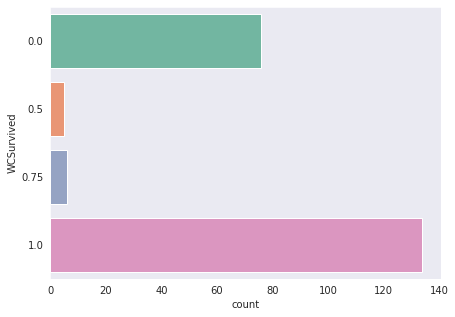

In [ ]:
print('WCSurvived all data values:')
print(data.WCSurvived.value_counts().to_string())
plt.figure(figsize=(7,5))
f = sns.countplot(y=data.WCSurvived)

In [ ]:
data[data['WCSurvived']==0.75]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Surname,Ticket_id,Group_id,Title,WC_count,WCSurvived
25,26,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,1.0,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,woman,6.0,0.75
182,183,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S,0.0,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,boy,6.0,0.75
233,234,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S,1.0,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,woman,6.0,0.75
261,262,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,1.0,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,boy,6.0,0.75
1045,1046,3,"Asplund, Master. Filip Oscar",male,13.0,4,2,347077,31.3875,NaN,S,NaN,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,boy,6.0,0.75
1270,1271,3,"Asplund, Master. Carl Edgar",male,5.0,4,2,347077,31.3875,NaN,S,NaN,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,boy,6.0,0.75


In [ ]:
data[data['WCSurvived']==0.50]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Surname,Ticket_id,Group_id,Title,WC_count,WCSurvived
297,298,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,0.0,Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,woman,3.0,0.5
305,306,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,1.0,Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,boy,3.0,0.5
498,499,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,0.0,Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,woman,3.0,0.5
708,709,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.55,NaN,S,1.0,Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,woman,1.0,0.5
1032,1033,1,"Daniels, Miss. Sarah",female,33.00,0,0,113781,151.55,NaN,S,NaN,Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,woman,1.0,0.5


グループにより死亡の予測が使えそう。
非整数の `WCSurvived` 値を持つのは11人だけで AllisonsとAsplunds家?です。 
彼らのほとんどが訓練データに含まれていることがわかりますので、テストセットの中で唯一の3人については、ジェンダーモデルを使用して、最善を期待します。 

In [ ]:
data.loc[(data.WCSurvived==0.75) | (data.WCSurvived==0.5), cols].sort_values(by='Group_id')

,PassengerId,Survived,WCSurvived,Name,Title,Group_id
297,298,0.0,0.50,"Allison, Miss. Helen Loraine",woman,Allison-1-11378-151.55-S
305,306,1.0,0.50,"Allison, Master. Hudson Trevor",boy,Allison-1-11378-151.55-S
498,499,0.0,0.50,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",woman,Allison-1-11378-151.55-S
708,709,1.0,0.50,"Cleaver, Miss. Alice",woman,Allison-1-11378-151.55-S
1032,1033,NaN,0.50,"Daniels, Miss. Sarah",woman,Allison-1-11378-151.55-S
25,26,1.0,0.75,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",woman,Asplund-3-34707-31.3875-S
182,183,0.0,0.75,"Asplund, Master. Clarence Gustaf Hugo",boy,Asplund-3-34707-31.3875-S
233,234,1.0,0.75,"Asplund, Miss. Lillian Gertrud",woman,Asplund-3-34707-31.3875-S
261,262,1.0,0.75,"Asplund, Master. Edvin Rojj Felix",boy,Asplund-3-34707-31.3875-S
1045,1046,NaN,0.75,"Asplund, Master. Filip Oscar",boy,Asplund-3-34707-31.3875-S


テストデータの中には、全構成員がいる家族群があるので 、それらは未知の家族の生存率を持っているものも家族のすべての構成要素が我々のWCGに従うとして

In [ ]:
# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), cols].sort_values(by='Group_id')

,PassengerId,Survived,WCSurvived,Name,Title,Group_id
1259,1260,NaN,NaN,"Gibson, Mrs. Leonard (Pauline C Boeson)",woman,Gibson-1-11237-59.4-C
1293,1294,NaN,NaN,"Gibson, Miss. Dorothy Winifred",woman,Gibson-1-11237-59.4-C
1044,1045,NaN,NaN,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",woman,Klasen-3-35040-12.1833-S
1154,1155,NaN,NaN,"Klasen, Miss. Gertrud Emilia",woman,Klasen-3-35040-12.1833-S
1050,1051,NaN,NaN,"Peacock, Mrs. Benjamin (Edith Nile)",woman,Peacock-3-SOTON/O.Q. 310131-13.775-S
1172,1173,NaN,NaN,"Peacock, Master. Alfred Edward",boy,Peacock-3-SOTON/O.Q. 310131-13.775-S
1300,1301,NaN,NaN,"Peacock, Miss. Treasteall",woman,Peacock-3-SOTON/O.Q. 310131-13.775-S
1083,1084,NaN,NaN,"van Billiard, Master. Walter John",boy,van Billiard-3-A/5. 85-14.5-S
1235,1236,NaN,NaN,"van Billiard, Master. James William",boy,van Billiard-3-A/5. 85-14.5-S


これらの家族は Gibson家、	Klasen家、Peacock家、van Billiard家である。



彼らを予測する必要があるので、どの女子供グループが生きるのか死ぬのかを決める。


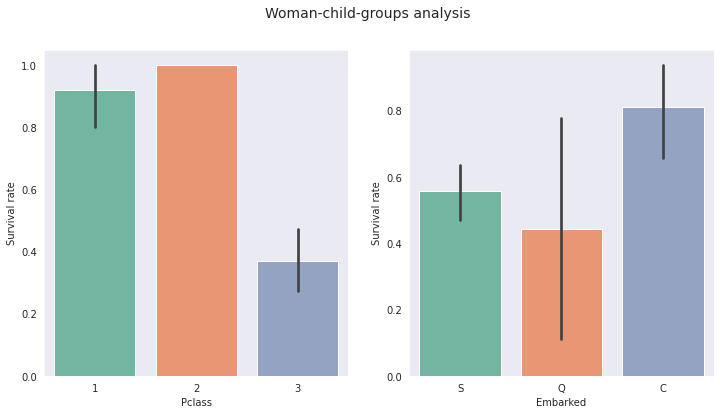

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Woman-child-groups analysis', fontsize=14)
a = sns.barplot(x='Pclass', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[0]).set_ylabel('Survival rate')
b = sns.barplot(x='Embarked', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[1]).set_ylabel('Survival rate')

`Pclass` 1か2で旅をしていた女性の子供グループはほとんどが生き残り、`Pclass` 3で旅をしていた女性の子供グループはほとんど死んでいる。
Gibson家は `Pclass` 1 と `Embarked` C、Klasen家、Peacock家、van Billiard家は `Pclass` 3 と `Embarked` Sを持っていたので、Gibson家は生き残り、他の3つの家族は死亡したと仮定するのが最善の方法である。



In [ ]:
# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

`WCSurvived` 値によるテストセットの乗客数の合計。

In [ ]:
print('WCSurvived test values:')
print(data[891:1309].WCSurvived.value_counts().to_string())

WCSurvived test values:
1.00    47
0.00    24
0.75     2
0.50     1


##WCGを今回のコンペの形式に合わせる。
テストデータセットには，女性と子供のグループに属する乗客が74人(47+24+2+1)いる． 
すべての女性が生きている一方で、すべての男性(子供を含む)が死亡することを単純に予測するジェンダーモデルに、以下の2つの予測ルールを適用させる。
* 成人した男性を除く家族全員が死亡しているすべての女性について、`WCSurvived`の列が0になるように死亡を予測する。
* 成人した男性を除く家族全員が、`WCSurvived`列が1に等しいように、すべての男子が生きていることを予測する。


In [ ]:
# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1, completing the gender model
data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1


# Change WCG women with WCSurvived=0 to 0
data.loc[891:1308,'Predict'][(data.Sex == 'female') & (data['WCSurvived'] == 0)] = 0
# Change WCG boys with WCSurvived=1 to 1, completing the WCG + gender model
data.loc[891:1308, 'Predict'][(data.Title == 'boy') & (data['WCSurvived'] == 1)] = 1
# With this, the three group members with non-integer WCSurvived are not changed from the gender model

上の予測ルールから、どの乗客が生死を予測されるのか。


In [ ]:
print('The following 8 males are predicted to live:')
cols = ['PassengerId', 'Name', 'Title', 'Group_id']
data[891:1309][cols].loc[(data.Title == 'boy') & (data.Predict == 1)]

The following 8 males are predicted to live:


,PassengerId,Name,Title,Group_id
955,956,"Ryerson, Master. John Borie",boy,Ryerson-1-PC 1760-262.375-C
980,981,"Wells, Master. Ralph Lester",boy,Wells-2-2910-23.0-S
1052,1053,"Touma, Master. Georges Youssef",boy,Touma-3-265-15.2458-C
1085,1086,"Drew, Master. Marshall Brines",boy,Drew-2-2822-32.5-S
1087,1088,"Spedden, Master. Robert Douglas",boy,Spedden-1-1696-134.5-C
1198,1199,"Aks, Master. Philip Frank",boy,Aks-3-39209-9.35-S
1283,1284,"Abbott, Master. Eugene Joseph",boy,Abbott-3-C.A. 267-20.25-S
1308,1309,"Peter, Master. Michael J",boy,Peter-3-266-22.3583-C


In [ ]:
print('The following 15 females are predicted to die:')
data[891:1309][cols].loc[(data.Title == 'woman') & (data.Predict == 0)]

The following 15 females are predicted to die:


,PassengerId,Name,Title,Group_id
909,910,"Ilmakangas, Miss. Ida Livija",woman,Ilmakangas-3-STON/O2. 310127-7.925-S
924,925,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",woman,Johnston-3-W./C. 660-23.45-S
928,929,"Cacic, Miss. Manda",woman,Cacic-3-31508-8.6625-S
1023,1024,"Lefebre, Mrs. Frank (Frances)",woman,Lefebre-3-413-25.4667-S
1031,1032,"Goodwin, Miss. Jessie Allis",woman,Goodwin-3-CA 214-46.9-S
1044,1045,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",woman,Klasen-3-35040-12.1833-S
1050,1051,"Peacock, Mrs. Benjamin (Edith Nile)",woman,Peacock-3-SOTON/O.Q. 310131-13.775-S
1079,1080,"Sage, Miss. Ada",woman,Sage-3-CA. 234-69.55-S
1140,1141,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",woman,Zabour-3-266-14.4542-C
1154,1155,"Klasen, Miss. Gertrud Emilia",woman,Klasen-3-35040-12.1833-S


In [ ]:
# output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
# output.to_csv('WCG_gender.csv', index=False)

WCGモデルだけの予測結果


# 非WCGの乗客(男性と女性)

In [ ]:
# Assign np.NaN to zero-fares
def fix_fare(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row
print('The following {:d} passengers have a zero Fare:'.format(data[data.Fare==0].shape[0]))
cols = ['PassengerId', 'Survived', 'Pclass','Fare', 'Name']
data.loc[data.Fare==0, cols]

The following 17 passengers have a zero Fare:


,PassengerId,Survived,Pclass,Fare,Name
179,180,0.0,3,0.0,"Leonard, Mr. Lionel"
263,264,0.0,1,0.0,"Harrison, Mr. William"
271,272,1.0,3,0.0,"Tornquist, Mr. William Henry"
277,278,0.0,2,0.0,"Parkes, Mr. Francis ""Frank"""
302,303,0.0,3,0.0,"Johnson, Mr. William Cahoone Jr"
413,414,0.0,2,0.0,"Cunningham, Mr. Alfred Fleming"
466,467,0.0,2,0.0,"Campbell, Mr. William"
481,482,0.0,2,0.0,"Frost, Mr. Anthony Wood ""Archie"""
597,598,0.0,3,0.0,"Johnson, Mr. Alfred"
633,634,0.0,1,0.0,"Parr, Mr. William Henry Marsh"


fix_fare 関数を使う前と使った後の比較。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; y

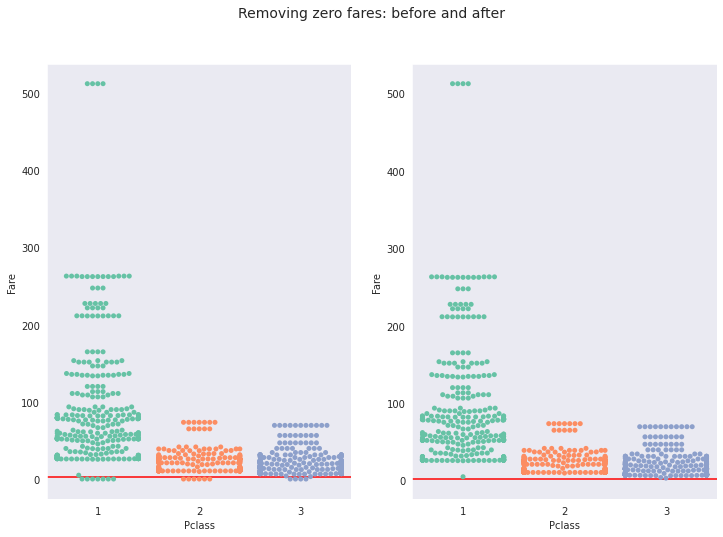

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Removing zero fares: before and after', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
ax[0].axhline(y=2, color='r')
# Apply the fix_fare function 
data = data.apply(fix_fare, axis='columns')
ax[1].axhline(y=2, color='r')
b = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[1])

次に、`Fare`カラムを再度修正して、乗客の`Fare`をチケットの頻度で割っただけの`Pfare`特徴量を作成する。
これでほとんどの場合で、`Fare` 特徴の範囲を狭め、外れ値を修正できる。 

In [ ]:
# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 66.4% of the points cannot be placed; y

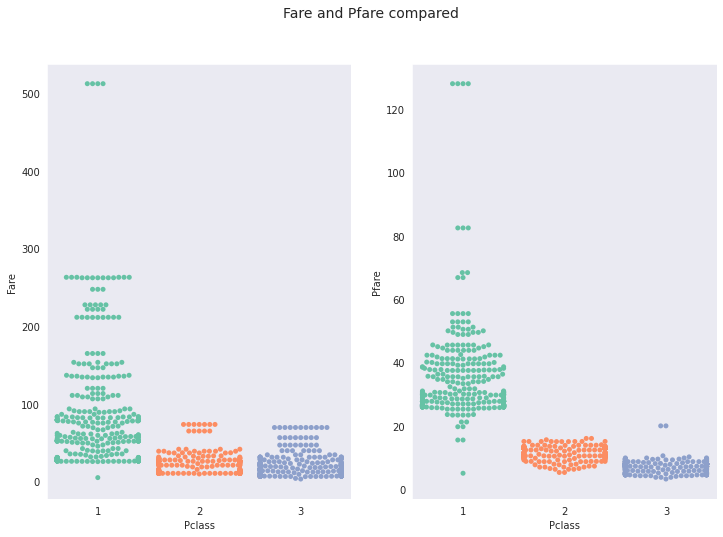

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Fare and Pfare compared', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
b = sns.swarmplot(x='Pclass', y='Pfare', data=data, ax=ax[1])

rangeは500以上から125に縮小され、2クラス目はよりコンパクトになり、3クラス目は本当に高い運賃でほとんどの外れ値がなくなった。

##非WCGである男性

In [ ]:
# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 26.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


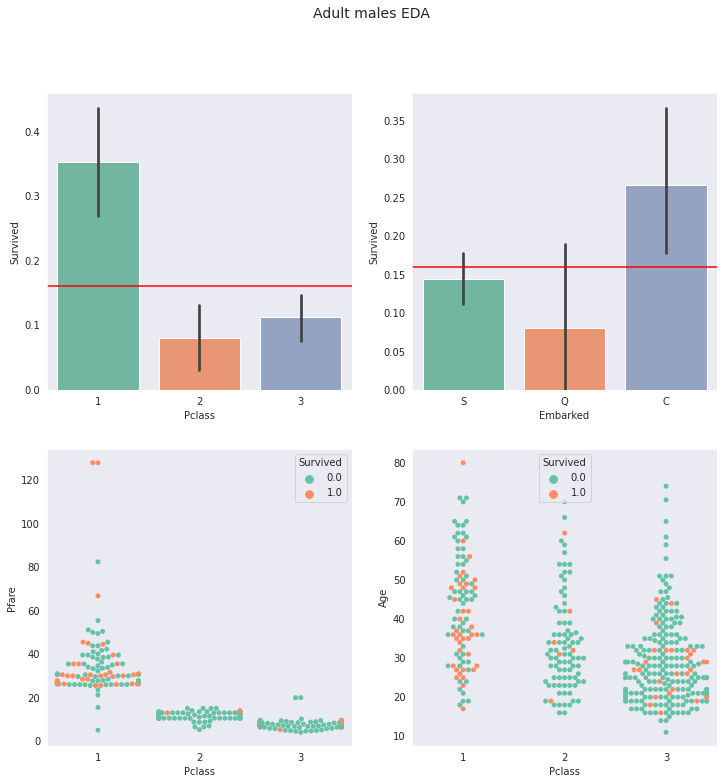

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Adult males EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_male, ax=ax[0][0])

ax[0][0].axhline(y=train_male.Survived.mean(), color='r')

sns.barplot(x='Embarked', y='Survived', data=train_male, ax=ax[0][1])

ax[0][1].axhline(y=train_male.Survived.mean(), color='r')

sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_male, ax=ax[1][0])
# ax[1][0].axhline(y=25, color='y')
# ax[1][0].axhline(y=32, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_male, ax=ax[1][1])

赤線は、trainデータの男性の平均値死亡率。
`Pclass`,`Embarked`は今回の予測するグループによっての特長が変わりそう。 
`Pfare`も`Pclass`でみてやると、なにかしら関係がありそうなので`Pclass`の値が高いと言えそう。`Age`は`Pclass`でみると散らばっててわかりにくそう。

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

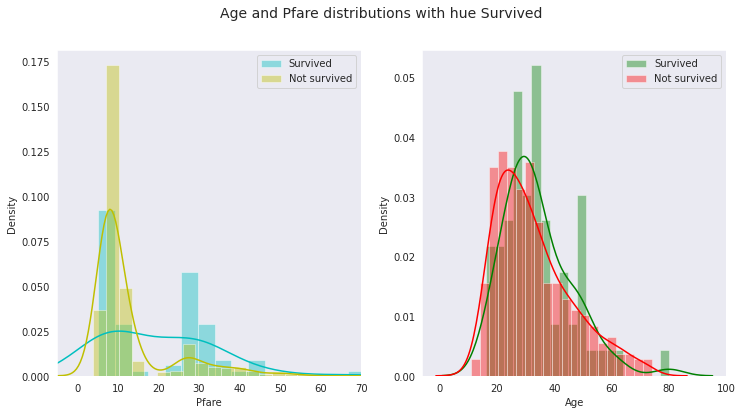

In [ ]:
x1 = train_male.loc[train_male['Survived']==1, 'Pfare']
x0 = train_male.loc[train_male['Survived']==0, 'Pfare']
y1 = train_male.loc[train_male['Survived']==1, 'Age']
y0 = train_male.loc[train_male['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(x1, bins=30, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(x0, bins=25, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.distplot(y1, bins=20, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(y0, bins=20, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

死んだ人と生き残った人との間の差が`Age` にはあまりなく、`Pfare`はそこそこあるので、 `Age`は使わないようにだけする。

## 非WCGの男性の予測

k_neighborsを変えた時のrecall(再現率)とprecision(適合率)の変化KNNモデルでどのように変化するか。


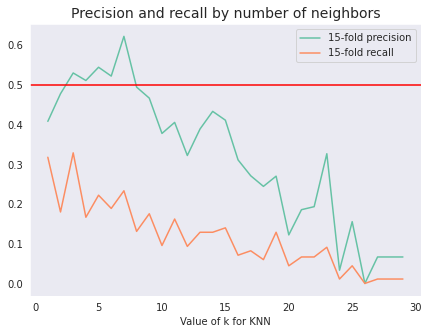

In [ ]:
cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Survived']
features = ['Pfare', 'Pclass', 'Embarked']
X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,30):
# for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,30)
# k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

recallとprecisionより、k値を1、3、7にする。 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



# 変更4LB0.847 
# これは結局knnに対する重みが大きすぎないか？まぁ、これにするか
# m1 = KNeighborsClassifier(n_neighbors=1)
# m2 = KNeighborsClassifier(n_neighbors=3)
# m3 = KNeighborsClassifier(n_neighbors=7)
# m4 = XGBClassifier(random_state=0)
# m5 = RandomForestClassifier(random_state=0)
############################
# 15-fold precision of the ensemble: 0.542
# 15-fold recall of the ensemble: 0.269
# 15-fold accuracy of the ensemble: 0.846
############################



# 変更3LB0.844 
# m1 = XGBClassifier(random_state=0)
# m2 = KNeighborsClassifier(n_neighbors=7) 
# m3 = RandomForestClassifier(random_state=0)
############################
# 15-fold precision of the ensemble: 0.563
# 15-fold recall of the ensemble: 0.231
# 15-fold accuracy of the ensemble: 0.844
############################



# 変更2LB0.844 
# m1 = XGBClassifier(random_state=0)
# m2 = KNeighborsClassifier(n_neighbors=3) 
# m3 = RandomForestClassifier(random_state=0)
############################
# 15-fold precision of the ensemble: 0.536
# 15-fold recall of the ensemble: 0.256
# 15-fold accuracy of the ensemble: 0.844
############################



# 変更1LB0.841 
# m1 = XGBClassifier(random_state=0)
# m2 = LGBMClassifier(random_state=0)
# m3 = RandomForestClassifier(random_state=0)
############################
# 15-fold precision of the ensemble: 0.546
# 15-fold recall of the ensemble: 0.242
# 15-fold accuracy of the ensemble: 0.847
############################



# 元LB0.847(アンサンブルがknnだけってどうなの) 
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# 数値的にこれだなやっぱ
############################
# 15-fold precision of the ensemble: 0.562
# 15-fold recall of the ensemble: 0.318
# 15-fold accuracy of the ensemble: 0.851
############################



# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
        # 変更4用
        # ('m1', m1), ('m2', m2), ('m3', m3), ('m4', m4), ('m5', m5)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
test_male.loc[(predictions_m==1), cols]

15-fold precision of the ensemble: 0.562
15-fold recall of the ensemble: 0.318
15-fold accuracy of the ensemble: 0.851


,PassengerId,Name,Pfare,Pclass,Embarked
919,920,"Brady, Mr. John Bertram",30.500000,1,S
925,926,"Mock, Mr. Philipp Edmund",28.875000,1,C
930,931,"Hee, Mr. Ling",7.061975,3,S
941,942,"Smith, Mr. Lucien Philip",30.000000,1,S
959,960,"Tucker, Mr. Gilbert Milligan Jr",28.537500,1,C
985,986,"Birnbaum, Mr. Jakob",26.000000,1,C
1022,1023,"Gracie, Col. Archibald IV",28.500000,1,C
1068,1069,"Stengel, Mr. Charles Emil Henry",27.720850,1,C
1096,1097,"Omont, Mr. Alfred Fernand",25.741700,1,C


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 75.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; y

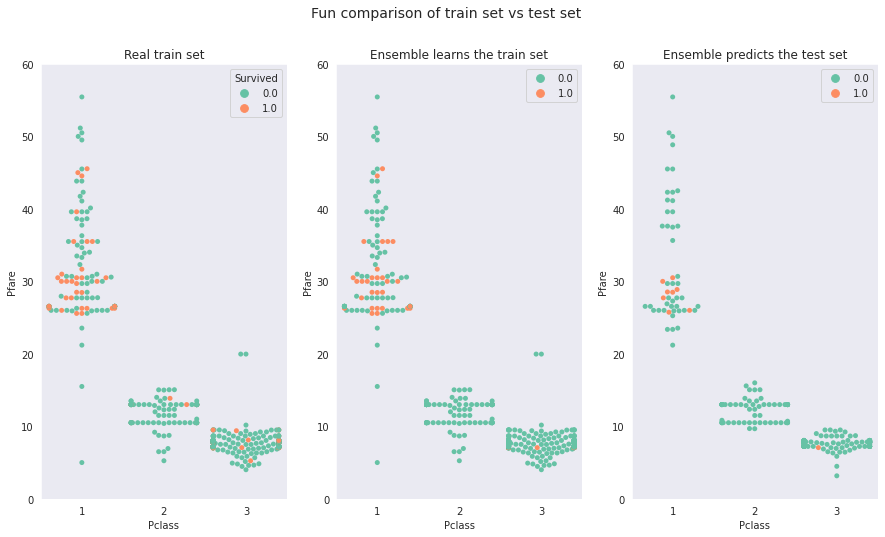

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=60)
a = sns.swarmplot(x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m,  ax=ax[2])

In [ ]:
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m
# output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
# output.to_csv('WCG_male.csv', index=False)

WCG＋男性の予測終わり

## 非WCGの女性

In [ ]:
train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

`Age`を使うか使わないか。 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 38.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 68.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


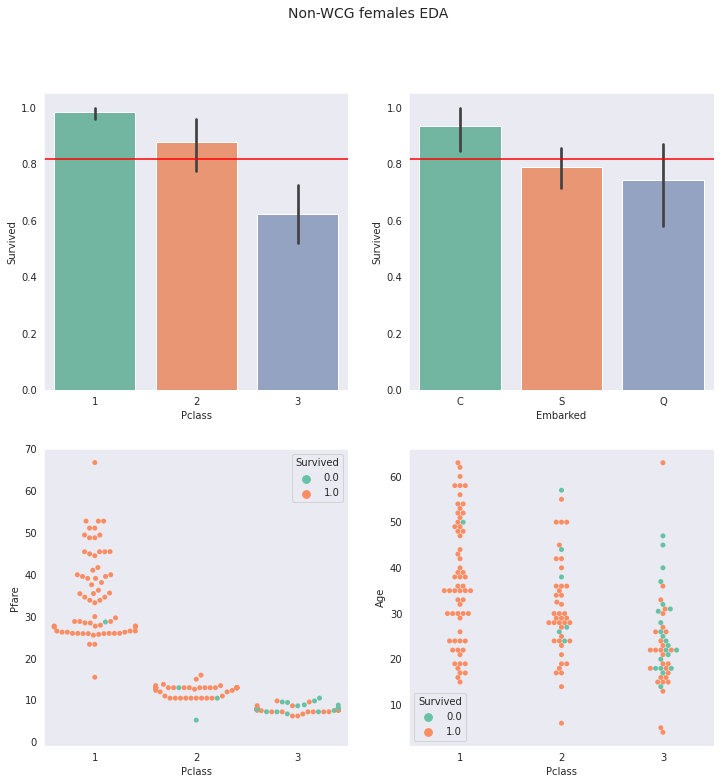

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Non-WCG females EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_female, ax=ax[1][0])
ax[1][0].set_ylim(top=70)
# ax[1][0].axhline(y=7, color='y')
# ax[1][0].axhline(y=10, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_female, ax=ax[1][1])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

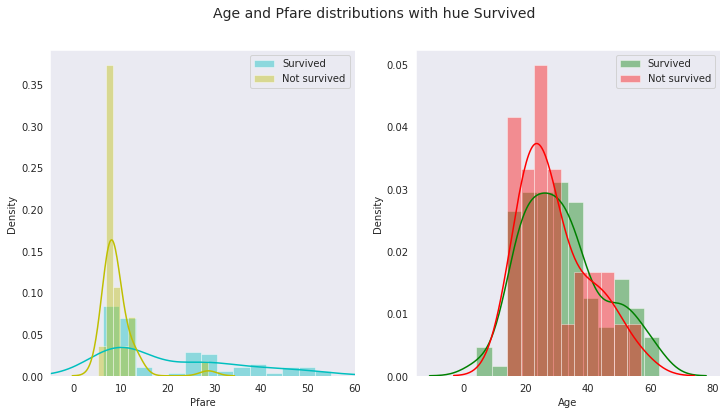

In [ ]:
w1 = train_female.loc[train_female['Survived']==1, 'Pfare']
w0 = train_female.loc[train_female['Survived']==0, 'Pfare']
z1 = train_female.loc[train_female['Survived']==1, 'Age']
z0 = train_female.loc[train_female['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(w1, bins=35, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(w0, bins=15, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(z0, bins=10, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

死んだ人と生き残った人との間の差が`Age` にはあまりなく、`Pfare`はそこそこあるので、 `Age`は使わないようにだけする。


## 非WCGの女性の予測

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score
# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

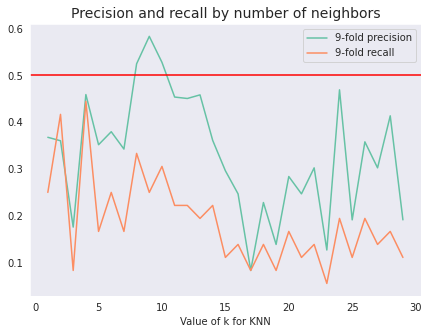

In [ ]:
y_f = train_female['Survived']
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1,30):
# for k in range(1,18):
    pipeline2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision).mean())
    recall_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall).mean())
    
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='9-fold precision')
plt.plot(k_range, recall_f, label='9-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

recallとprecisionよりk値が4, 9, 11にする。

In [ ]:
f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])
print('9-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_precision).mean()))
print('9-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_recall).mean()))
print('9-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()))
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
test_female.loc[(predictions_f==0), cols]

9-fold precision of the ensemble: 0.571
9-fold recall of the ensemble: 0.278
9-fold accuracy of the ensemble: 0.813


,PassengerId,Name,Pfare,Pclass,Embarked
1060,1061,"Hellstrom, Miss. Hilda Maria",8.9625,3,S
1088,1089,"Nilsson, Miss. Berta Olivia",7.7750,3,S
1105,1106,"Andersson, Miss. Ida Augusta Margareta",7.7750,3,S
1250,1251,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",7.7750,3,S
1267,1268,"Kink, Miss. Maria",8.6625,3,S
1303,1304,"Henriksson, Miss. Jenny Lovisa",7.7750,3,S


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.2% of the points cannot be placed; y

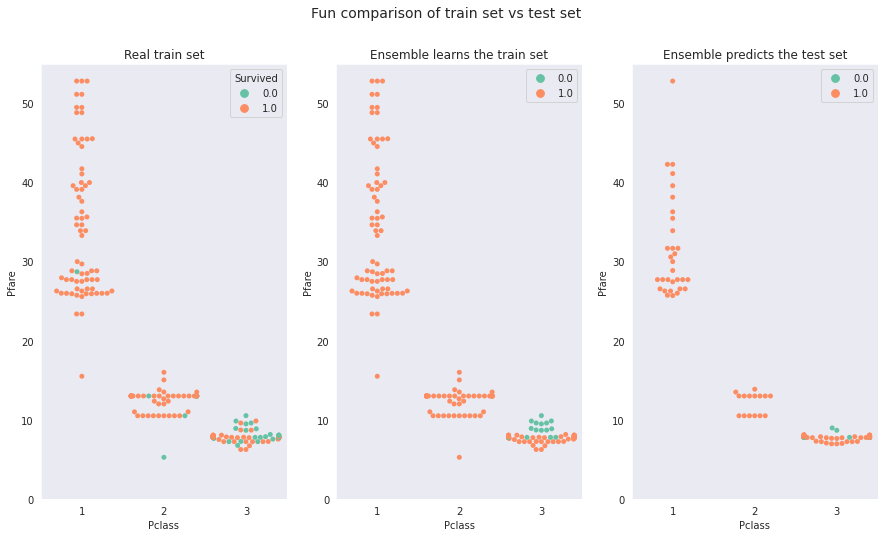

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=55)
a = sns.swarmplot(x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f,  ax=ax[2])

## 最終提出物

In [ ]:
data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

今回のコンペようにSurvivedをPerishedへ変換

In [ ]:
output.loc[output['Survived'] == 1, 'Perished'] = int(0)
output.loc[output['Survived'] == 0, 'Perished'] = int(1)
output =  output.drop('Survived',axis=1)
output.head()

,PassengerId,Perished
891,892,1.0
892,893,0.0
893,894,1.0
894,895,1.0
895,896,0.0


In [ ]:
submission['Perished'] = list(map(int,output['Perished'].values))

In [ ]:
submission.head()

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0


In [ ]:
submission.to_csv('submission.csv',index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#まとめ


まず、乗客（train＋test）を4つのグループに分ける。
1. 成人男性・・・人口の60％（A
1. 若い男の子（マスターの称号を持つ）・・・人口の5％（B
1. 子供、姉妹、母親がいる女性（兄弟、夫は任意）・・・人口の13％（C
1. 兄弟や夫がいる女性（子供がいない、姉妹がいない、母親がいない）、または一人旅をしている女性-人口の22％（D

次に、3つの分類器を構築
1. (B) + (C)を分類するための**ジェンダーモデル**の上に**WCG**を追加した。
1. 分類するためのKNN, ~~xgb, lr~~の**nsemble_1**(A)
1. 分類するKNNの**Ensemble_2**(D)